# Compare similarity of image after rotation
- On the function points branch of nengo
- On the vision branch of nengo_extras

In [1]:
import nengo
import numpy as np
import cPickle
from nengo_extras.data import load_mnist
from nengo_extras.vision import Gabor, Mask
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.ndimage
from skimage.measure import compare_ssim as ssim
import random

Load the MNIST database

In [2]:
# --- load the data
img_rows, img_cols = 28, 28

(X_train, y_train), (X_test, y_test) = load_mnist()

X_train = 2 * X_train - 1  # normalize to -1 to 1
X_test = 2 * X_test - 1  # normalize to -1 to 1


Each digit is represented by a one hot vector where the index of the 1 represents the number

In [3]:
temp = np.diag([1]*10)

ZERO = temp[0]
ONE =  temp[1]
TWO =  temp[2]
THREE= temp[3]
FOUR = temp[4]
FIVE = temp[5]
SIX =  temp[6]
SEVEN =temp[7]
EIGHT= temp[8]
NINE = temp[9]

labels =[ZERO,ONE,TWO,THREE,FOUR,FIVE,SIX,SEVEN,EIGHT,NINE]

dim =28

Load the saved weight matrices that were created by training the model

In [5]:
label_weights = cPickle.load(open("label_weights1000.p", "rb"))
activity_to_img_weights = cPickle.load(open("activity_to_img_weights1000.p", "rb"))
#rotated_clockwise_after_encoder_weights =  cPickle.load(open("rotated_after_encoder_weights_clockwise5000.p", "r"))
rotated_counter_after_encoder_weights =  cPickle.load(open("rotated_after_encoder_weights1000.p", "r"))

two_img_similarity_ssim_weights = cPickle.load(open("two_img_similarity_ssim_weights2000.p"))
two_img_similarity_dot_weights = cPickle.load(open("two_img_similarity_dot_weights2000.p"))


#identity_after_encoder_weights = cPickle.load(open("identity_after_encoder_weights1000.p","r"))


#rotation_clockwise_weights = cPickle.load(open("rotation_clockwise_weights1000.p","rb"))
#rotation_counter_weights = cPickle.load(open("rotation_weights1000.p","rb"))


Functions to perform the inhibition of each ensemble

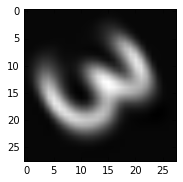

In [23]:
#Create stimulus at angle
weight = np.dot(label_weights,activity_to_img_weights)

img = np.dot(THREE,weight)

plt.subplot(121)
pylab.imshow(img.reshape(28,28),cmap="gray")


#img =X_train[7] 
rot_img =scipy.ndimage.interpolation.rotate(img.reshape(28,28),-60,reshape=False,cval=-1).ravel()

pylab.imshow(rot_img.reshape(28,28),cmap='gray')
plt.show()

In [24]:
'''For direct mode and nodes
def ssim_func(x):
    
    img1 = np.dot(x[:1000],activity_to_img_weights)
    img2 = np.dot(x[1000:],activity_to_img_weights)
    return ssim(img1.reshape(28,28),img2.reshape(28,28))

def activity_sim_func(x):
    u=x[:1000]
    v=x[1000:]
    
    #a= nengo.spa.similarity(u,v,normalize=True)
    a = np.dot(u,v)
    
    return a
'''

'For direct mode and nodes\ndef ssim_func(x):\n    \n    img1 = np.dot(x[:1000],activity_to_img_weights)\n    img2 = np.dot(x[1000:],activity_to_img_weights)\n    return ssim(img1.reshape(28,28),img2.reshape(28,28))\n\ndef activity_sim_func(x):\n    u=x[:1000]\n    v=x[1000:]\n    \n    #a= nengo.spa.similarity(u,v,normalize=True)\n    a = np.dot(u,v)\n    \n    return a\n'

## The network where the mental imagery and rotation occurs
- The state, seed and ensemble parameters (including encoders) must all be the same for the saved weight matrices to work
- The number of neurons (n_hid) must be the same as was used for training
- The input must be shown for a short period of time to be able to view the rotation
- The recurrent connection must be from the neurons because the weight matices were trained on the neuron activities


In [25]:
rng = np.random.RandomState(9)
n_hid = 1000
model = nengo.Network(seed=3)
with model:
    #Stimulus to be matched to
    static_stim = nengo.Node(img)
    
    #Stimulus only shows for brief period of time
    rot_stim = nengo.Node(lambda t: rot_img if t < 0.1 else 0)
    
    
    ens_params = dict(
        eval_points=X_train,
        neuron_type=nengo.LIF(), 
        intercepts=nengo.dists.Choice([-0.5]),
        max_rates=nengo.dists.Choice([100]),
        )
        
    
    # linear filter used for edge detection as encoders, more plausible for human visual system
    encoders = Gabor().generate(n_hid, (11, 11), rng=rng)
    encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)

    #Ensemble that represents the image to be matched
    static_ens = nengo.Ensemble(n_neurons=n_hid, dimensions=784,seed=3, encoders=encoders, **ens_params) #Direct? cannot because similarity between activities
    nengo.Connection(static_stim, static_ens)
    
    #Ensemble that represents the image and will be rotated
    ens = nengo.Ensemble(n_hid, dim**2, seed=3, encoders=encoders, **ens_params)
    

    #Connect stimulus to ensemble, transform using learned weight matrices
    nengo.Connection(rot_stim, ens)
    
    #Recurrent connection on the neurons of the ensemble to perform the rotation
    nengo.Connection(ens.neurons, ens.neurons, transform = rotated_counter_after_encoder_weights.T, synapse=0.1)

    '''
    #combine ens has different parameters
    ens_params_combine = dict(
        eval_points=imgs, 
        neuron_type=nengo.LIF(), #originally used LIFRate()
        intercepts=nengo.dists.Choice([-0.5]),
        max_rates=nengo.dists.Choice([100]),
    )
    
    encoders_combine = Gabor().generate(n_hid*2, (11, 11), rng=rng)
    encoders_combine = Mask((56, 28)).populate(encoders_combine, rng=rng, flatten=True)
    '''
    #Bring two images together to calculate similarity
    combine = nengo.Ensemble(2000, 784*2)#,seed=3,encoders=encoders_combine,**ens_params_combine) #Not direct, connections to actual neurons
    #combine = nengo.Ensemble(1000, 10000, neuron_type=nengo.Direct())
    
    #Connect the ensembles into one larger ensemble
    nengo.Connection(static_ens.neurons,combine.neurons[:1000])
    nengo.Connection(ens.neurons, combine.neurons[1000:])
    
    #structural similarity measure
    ssim_node = nengo.Node(None, size_in=1)
    nengo.Connection(combine.neurons, ssim_node, transform=two_img_similarity_ssim_weights)
    
    #Trained similarity of activities using dot product
    activity_sim_node = nengo.Node(None,size_in=1)
    nengo.Connection(combine.neurons, activity_sim_node, transform=two_img_similarity_dot_weights)
    
    #Collect output, use synapse for smoothing
    probe = nengo.Probe(ens.neurons,synapse=0.1)
    static_probe = nengo.Probe(static_ens.neurons,synapse=0.1)
    ssim_probe = nengo.Probe(ssim_node,synapse=0.1)
    activity_sim_probe = nengo.Probe(activity_sim_node,synapse=0.1)
    

In [26]:
sim = nengo.Simulator(model)

In [27]:
sim.run(5)

Simulation finished in 0:00:23.                                                 


## The following is not part of the brain model, it is used to view the output for the ensemble
Since it's probing the neurons themselves, the output must be transformed from neuron activity to visual image

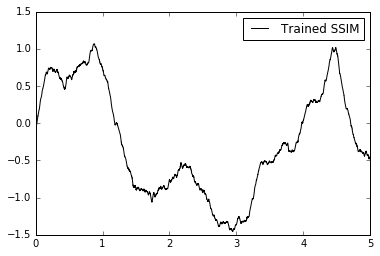

In [28]:
%matplotlib inline
#Graph of probe output
plt.plot(sim.trange(), sim.data[ssim_probe], 'k', label="Trained SSIM")
plt.legend()
plt.show()

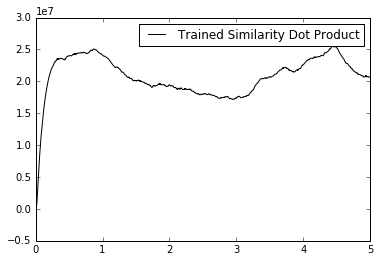

In [29]:
#Graph of probe output
plt.plot(sim.trange(), sim.data[activity_sim_probe], 'k', label="Trained Similarity Dot Product")
plt.legend()
plt.show()

In [32]:
#Turn probe activity to img
output_acts = []
for act in sim.data[probe]:
    output_acts.append(np.dot(act,activity_to_img_weights))

In [83]:
'''Animation for Probe output'''
fig = plt.figure()


def updatefig(i):
    im = pylab.imshow(np.reshape(output_acts[i],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'),animated=True)
    
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=0.1, blit=True)
plt.show()

AttributeError: 'NoneType' object has no attribute 'tk'

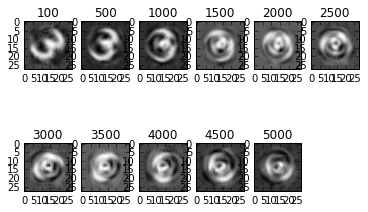

In [33]:
#ouput_acts = sim.data[probe]

plt.subplot(261)
plt.title("100")
pylab.imshow(np.reshape(output_acts[100],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(262)
plt.title("500")
pylab.imshow(np.reshape(output_acts[500],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(263)
plt.title("1000")
pylab.imshow(np.reshape(output_acts[1000],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(264)
plt.title("1500")
pylab.imshow(np.reshape(output_acts[1500],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(265)
plt.title("2000")
pylab.imshow(np.reshape(output_acts[2000],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(266)
plt.title("2500")
pylab.imshow(np.reshape(output_acts[2500],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(267)
plt.title("3000")
pylab.imshow(np.reshape(output_acts[3000],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(268)
plt.title("3500")
pylab.imshow(np.reshape(output_acts[3500],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(269)
plt.title("4000")
pylab.imshow(np.reshape(output_acts[4000],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(2,6,10)
plt.title("4500")
pylab.imshow(np.reshape(output_acts[4500],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(2,6,11)
plt.title("5000")
pylab.imshow(np.reshape(output_acts[4999],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))


plt.show()

Pickle the probe's output if it takes a long time to run

In [ ]:
#The filename includes the number of neurons and which digit is being rotated
filename = "mental_rotation_output_ONE_"  + str(n_hid) + ".p"
cPickle.dump(sim.data[probe], open( filename , "wb" ) )

## Testing

In [171]:
testing = np.dot(ONE,np.dot(label_weights,activity_to_img_weights))
testing = output_acts[300]
plt.subplot(131)
pylab.imshow(np.reshape(testing,(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

#Get image
#testing = np.dot(ONE,np.dot(label_weights,activity_to_img_weights))
#noise = np.random.random([28,28]).ravel()
testing = node_func(0,testing)

plt.subplot(132)
pylab.imshow(np.reshape(testing,(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))


#Get activity of image
_, testing_act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=testing)

#Get encoder outputs
testing_filter = np.dot(testing_act,rotated_counter_after_encoder_weights_filter)

#Get activities
testing_filter = ens.neuron_type.rates(testing_filter, sim.data[ens].gain, sim.data[ens].bias)

for i in range(5):
    testing_filter = np.dot(testing_filter,rotated_counter_after_encoder_weights_filter)
    testing_filter = ens.neuron_type.rates(testing_filter, sim.data[ens].gain, sim.data[ens].bias)
    testing_filter = np.dot(testing_filter,activity_to_img_weights)
    testing_filter = node_func(0,testing_filter)
    _, testing_filter = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=testing_filter)


#testing_rotate = np.dot(testing_rotate,rotation_weights)

testing_filter = np.dot(testing_filter,activity_to_img_weights)

plt.subplot(133)
pylab.imshow(np.reshape(testing_filter,(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

plt.show()

In [ ]:

plt.subplot(121)
pylab.imshow(np.reshape(X_train[0],(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

#Get activity of image
_, testing_act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=X_train[0])

testing_rotate = np.dot(testing_act,activity_to_img_weights)

plt.subplot(122)
pylab.imshow(np.reshape(testing_rotate,(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

plt.show()

## Just for fun

In [ ]:
letterO = np.dot(ZERO,np.dot(label_weights,activity_to_img_weights))
plt.subplot(161)
pylab.imshow(np.reshape(letterO,(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

letterL = np.dot(SEVEN,label_weights)
for _ in range(30):
    letterL = np.dot(letterL,rotation_weights)
letterL = np.dot(letterL,activity_to_img_weights)
plt.subplot(162)
pylab.imshow(np.reshape(letterL,(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

letterI = np.dot(ONE,np.dot(label_weights,activity_to_img_weights))
plt.subplot(163)
pylab.imshow(np.reshape(letterI,(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))
plt.subplot(165)
pylab.imshow(np.reshape(letterI,(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

letterV = np.dot(SEVEN,label_weights)
for _ in range(40):
    letterV = np.dot(letterV,rotation_weights)
letterV = np.dot(letterV,activity_to_img_weights)
plt.subplot(164)
pylab.imshow(np.reshape(letterV,(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

letterA = np.dot(SEVEN,label_weights)
for _ in range(10):
    letterA = np.dot(letterA,rotation_weights)
letterA = np.dot(letterA,activity_to_img_weights)
plt.subplot(166)
pylab.imshow(np.reshape(letterA,(dim, dim), 'F').T, cmap=plt.get_cmap('Greys_r'))

plt.show()